In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [55]:
class GridWorld():
    UP = (+1,  0)
    DOWN  = (-1, 0)
    LEFT = ( 0, -1)
    RIGHT  = ( 0, +1)
    ACTIONS = [UP, DOWN, LEFT, RIGHT]
    AGENT_START = (0,0)
    
    def __init__(self, shape, probability, walls, traps, difficult, goal):
        self.rows, self.cols = shape
        self.probability = probability
        self.walls = set(walls)
        self.traps = set(traps)
        self.difficult = set(difficult)
        self.goal = goal
        self.agent_state = GridWorld.AGENT_START

        self.grid = np.zeros((self.rows, self.cols))
        self.grid[self.goal[0], self.goal[1]] = 1

        for wall in self.walls:
            self.grid[wall[0], wall[1]] = -1
            
        for trap in self.traps:
            self.grid[trap[0], trap[1]] = -0.5
            
        for tile in self.difficult:
            self.grid[tile[0], tile[1]] = -0.2

    # code for displaying the created grid world
    def displayGridWorld(self):
      for i in range(self.rows):
        for j in range(self.cols):
            if (i, j) == self.agent_state:
                print("A", end=' ')
            elif (i, j) == self.goal:
                print("G", end=' ')
            elif (i, j) in self.walls:
                print("X", end=' ')
            elif (i, j) in self.traps:
                print("T", end=' ')
            elif (i, j) in self.difficult:
                print("D", end=' ')
            else:
                print(".", end=' ')
        print()

    def _getStates(self):
        return [(i, j) for i in range(self.rows)
                    for j in range(self.cols) if (i, j) not in self.walls]
    
    def getProbsGivenState(self, state, action):
        transition_probabilities = {}

        for x in range(self.rows):
            for y in range(self.cols):
                state = (x, y)
                for ACTIONS in GridWorld.ACTIONS:
                    new_x = state[0] + action[0]
                    new_y = state[1] + action[1]
                    next_state = (new_x if 0 <= new_x < self.rows else state[0], new_y if 0 <= new_y < self.cols else state[1])
                    transition_probabilities[(state, action)] = [(next_state, self.probability)]

        return transition_probabilities

    def _getReward(self, state):
        if state in self.goal:
            return 10
        elif state in self.traps:
          return -0.5
        elif state in self.difficult:
          return -0.2
        else:
            return -0.04

    def _is_done(self, state):
        return state == self.goal or state in self.traps or state in self.walls

    def _moveAgent(self, state, action):
        new_x = state[0] + action[0]
        new_y = state[1] + action[1]
        next_state = (new_x if 0 <= new_x < self.rows else state[0], new_y if 0 <= new_y < self.cols else state[1])

        reward = self.getReward(next_state)
        is_done = self._is_done(next_state)

        return next_state, reward, is_done

    def _resetWorld(self):
      self.agent_state = GridWorld.AGENT_START

    def _policy(self, state):
        # Get the direction of the goal state from the current state
        goal_direction = np.subtract(self.goal, state)

        # Choose a random action with probability 0.2
        if np.random.rand() < 0.2:
             return random.choice(GridWorld.ACTIONS)
        else:
            # Choose the action that moves in the direction of the goal state. This assumes that the actions are represented as integers, 
            # with 0 representing "up", 1 representing "down", 2 representing "left", and 3 representing "right".
            action_index = np.argmax(goal_direction)
        return GridWorld.ACTIONS[action_index]

    def generate_episodes(self, policy, num_episodes):
      episodes = []
      for i in range(num_episodes):
          episode = []
          state = self.agent_state
          done = False
          while not done:
              action = policy(state)
              next_state, reward, done = self.moveAgent(state, action)
              episode.append((state, action, reward))
              state = next_state
          episodes.append(episode)
          self.resetWorld()
      return episodes
 
    def compute_value_function(self, num_episodes, discount_factor):
      # Initialize the value function to all zeros
      value_function = {state: 0 for state in self.getStates()}

      # Keep track of the total return and the number of visits for each state
      returns = {state: [] for state in self.getStates()}
      visits = {state: 0 for state in self.getStates()}

      episodes = self.generate_episodes(self.policy, num_episodes)
      # Iterate over each episode and update the returns and visits for each state
      for episode in episodes:
          G = 0
          for t in range(len(episode)):
              state, _, reward = episode[t]
              G = discount_factor * G + reward

              # Add the total return and increment the number of visits for the current state
              visits[state] += 1
              returns[state].append(G)

      # Compute the average return for each state and update the value function
      for state in self.getStates():
          if visits[state] > 0:
              value_function[state] = sum(returns[state]) / visits[state]

      return value_function

    def visualize_value_function(self, value_function):
      # Create a grid of the same size as the value function
      grid = np.zeros((self.rows, self.cols))

      # Populate the grid with the values from the value function
      for state, value in value_function.items():
          x, y = state
          grid[x, y] = value

      # Create a plot of the grid with a color map
      fig, ax = plt.subplots()
      im = ax.imshow(grid, cmap="coolwarm")

      # Set the tick labels to the state indices
      ax.set_xticks(np.arange(self.cols))
      ax.set_yticks(np.arange(self.rows))
      ax.set_xticklabels(np.arange(self.cols))
      ax.set_yticklabels(np.arange(self.rows))

      # Rotate the tick labels and set their alignment
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

      # Loop over data dimensions and create text annotations
      for i in range(self.rows):
          for j in range(self.cols):
              text = ax.text(j, i, "{:.2f}".format(grid[i, j]),
                            ha="center", va="center", color="w")

      # Add a color bar
      cbar = ax.figure.colorbar(im, ax=ax)
      cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

      # Set the title of the plot
      ax.set_title("Value Function")

      # Show the plot
      plt.show()

In [56]:
my_grid_test = GridWorld((10,10), 0.25, [(3,3), (3,4), (3,5), (4,2), (5,2)], [(8,7)], [(1,2), (6,7)], (9,9))

In [53]:
my_grid_test.displayGridWorld()

A . . . . . . . . . 
. . D . . . . . . . 
. . . . . . . . . . 
. . . X X X . . . . 
. . X . . . . . . . 
. . X . . . . . . . 
. . . . . . . D . . 
. . . . . . . . . . 
. . . . . . . T . . 
. . . . . . . . . G 


In [61]:
values = my_grid_test.compute_value_function(100000, 1)

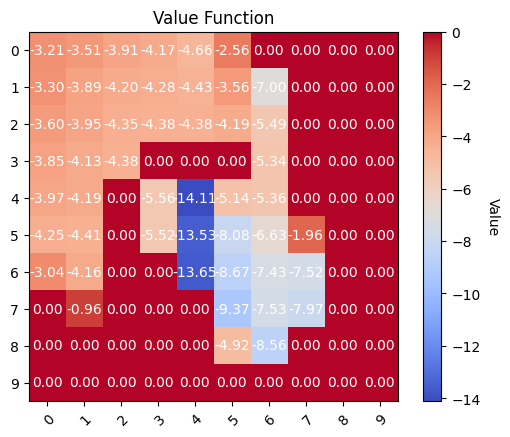

In [62]:
my_grid_test.visualize_value_function(values)